<a href="https://colab.research.google.com/github/elan-wilkinson/OrientationDetectionLegoAerospaceAssembly/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of Orientation Detection of LEGO Shuttle Assembly
Contributors: Elan Wilkinson, Ahmad Milad, Pallav Kamojjhala

Understanding the orientation of parts of an assembly or larger structure is of pivotal importance for their correct installation and quality inspection of that installation. The task of human or robotic assembly and detecting improper rotation or assemblage is shared problem in a broad variety of domains from aerospace, automobile manufacturing, industrial production engineering, medical device assemblage, and amny others.

This project seeks to determine feasibility and accuracy of rotation detection of a three dimensional object using computer vision without depth information, using models which are capable of running in real time and using simpler architectures WITH transfer learning. The selected models use learned features rather than requiring human determined features for better scalability, and for extensibility for training additional models on other parts or changing parts over time.

# LEGO Shuttle Orientation Detction Using Residual Neural Network (ResNet)


### Import Necessary Libraries

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F


### Connection to Drive Storage

In [2]:
# Connect to Drive Storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import of Synthetic Data and Annotation Files

Multiple sets of synthetic data were generated. Prior to establishing the focus on the shuttle assembly, data generation and orientation detection were explored on vehicles, puzzle parts, and a dinosaur toy. Testing only on synthetic data with the dinosaur toy, results were extremely accurage, typically within less than five degrees, which encouraged pursuit of this particular architecture.

Not shown here, a YOLO and basic CNN approach were develped, with signicantly poorer results, so these were trimmed and discarded.

Ultimately, three main sets of synthetic data were generated for end usage, each consisting of 20,000 images; one of the largest shuttle piece, at varying distances and off center, one of a secondary piece, at varying distances and off center, and one of the largest shuttle piece, in center and relatively close, simulating use either on close objects, or on images that have been cropped depending on their detected bounding box with some padding to avoid clipping.

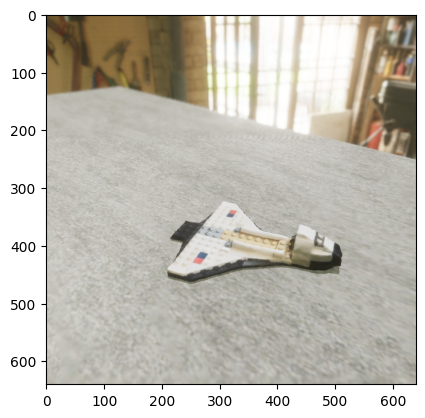

In [ ]:
# display image at sequence.0/step0.camera.png
img = Image.open(os.path.join(shuttle_images_dir, "sequence.11/step0.camera.png"))
plt.imshow(img)

# Synthetic Image Generation
In most modern industrial contexts, Computer-Aided Design (CAD) models would be available for synthetic data generation. Older engineering data typically lacks this would require either creation of these models or capture of the structure via scans.

In a similar manner to the latter context, the chosen testing item lacked CAD and it was necessary to generate a 3D representation for syntehtic image generation.

Minimal scan cleanup was performed in [Blender](https://www.blender.org/) to remove the surface below the scanned object, to again simulate minimal human effort in the pipeline of scan to data generation to model training.

This was performed using the tool [Scaniverse](https://scaniverse.com/), which uses Gaussian splatting to generate rich volumetric point clouds which can be automatically converted to 3-Dimension textured models. The device hardware used for this capture with Scaniverse was an iPhone 13 mini.

This 3D model was then imported into [Unity 6](https://unity.com/releases/unity-6) which was then used to generate the synthetic images using the [Perception](https://docs.unity3d.com/Packages/com.unity.perception@1.0/manual/index.html) package.

In addition to using the 3D scanned model, High Dynamic Range Images (HDRI) backgrounds from [Poly Haven](https://polyhaven.com/hdris) were used as well as various free table models from [Turbosquid](https://www.turbosquid.com/) on which the scanned models were placed.


**Features randomized during synthetic data generation include:**
- camera angle relative to the model
- camera position relative to the model
- camera distance from the model
- the background image used
- the rotation of the background image
- the angle of the light
- the temperature of the light
- the brightness of the light
- the table or surface the model was resting on

The project was set up so that the part in question being captured could easily be swapped out at will for other parts.

Unity is generally capable of running in a scripted headless manner, so in future iterations, this could be incorporated into a pipeline.

Annotations generated during training included Euler rotation, Quaternion rotation, 2-Dimensional screen bounding boxes, and 3-Dimensional bounding boxes.

In [3]:
shuttle_euler_text_file = '/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/0.txt'
shuttle_euler_rots_df = pd.read_csv(shuttle_euler_text_file, sep=",", header=None)

In [4]:
shuttle_euler_rots_df = shuttle_euler_rots_df.rename(columns={0: 'x'})
shuttle_euler_rots_df = shuttle_euler_rots_df.rename(columns={1: 'y'})
shuttle_euler_rots_df = shuttle_euler_rots_df.rename(columns={2: 'z'})

In [5]:
shuttle_euler_rots_df = (shuttle_euler_rots_df - 180.0)/180.0

In [6]:
shuttle_euler_rots_df['img name'] = ""
# create annotations file:
for i in range(0,20001):
  shuttle_euler_rots_df.loc[i, 'img name'] = "sequence." + str(i) + "/" + "step0.camera.png"

In [7]:
shuttle_euler_rots_df = shuttle_euler_rots_df.reindex(columns=['img name', 'x', 'y', 'z'])

In [8]:
shuttle_euler_rots_df.tail(5)

,img name,x,y,z
19996,sequence.19996/step0.camera.png,-0.711986,-0.290344,-1.0
19997,sequence.19997/step0.camera.png,-0.652041,0.259622,-1.0
19998,sequence.19998/step0.camera.png,-0.803894,-0.423482,-1.0
19999,sequence.19999/step0.camera.png,-0.854223,0.974591,-1.0
20000,sequence.20000/step0.camera.png,-0.737619,0.796913,-1.0


### Example Image from Synthetic Dataset

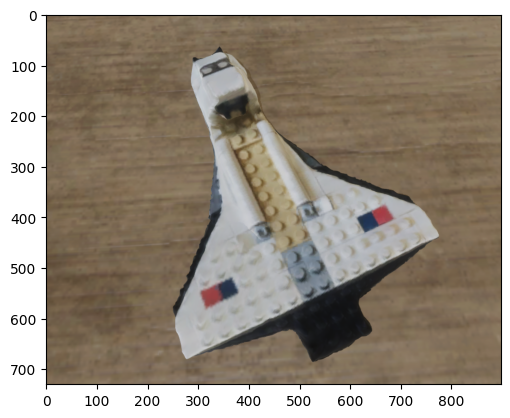

In [14]:
img = Image.open('/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/solo/sequence.0/step0.camera.png')
plt.imshow(img)

## Model Creation



After experimenting with multiple pre-trained YOLO and non-pre-trained CNN approaches, the use of a residual neural network pretrained on the ImageNet dataset demonstrated the best performance. Using a deeper 50 layer ResNet model offered comparable results to the 18 layer variant, so the latter was selected for faster performance for real-time usage.

After exploration with multiple optimizers, Adam with learning rate of 0.0001 appear to offer best results and MSE was used for loss. Interestingly, when exploring other loss options, such as angle or vector differences for loss, results were less accurate than the more general approach of using the mean squared error, so MSE was used in all subsequent training and the final model version.

In [10]:
# Define the custom model
class ResNetRotationModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetRotationModel, self).__init__()
        # Load a pre-trained ResNet model
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        # Replace the fully connected layer with a custom head for regression
        self.backbone.fc = nn.Linear(num_features, 3)  # Output x, y, z rotations

    def forward(self, x):
        return self.backbone(x)

# Define a custom dataset
class RotationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        # Load image
        img_name = os.path.join(self.image_dir, str(self.annotations.iloc[idx, 0]))
        image = Image.open(img_name).convert("RGB")

        # Load rotation labels (x, y, z)
        rotation_labels = self.annotations.iloc[idx, 1:4].values.astype('float')
        rotation_labels = torch.tensor(rotation_labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, rotation_labels

# Paths
images = '/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/solo/'
annotations_file = shuttle_euler_rots_df

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ResNet
])

# Split data
train_annotations, test_annotations = train_test_split(annotations_file, test_size=0.2, random_state=42)


train_dataset = RotationDataset(image_dir=images, annotations=train_annotations, transform=transform)
test_dataset = RotationDataset(image_dir=images, annotations=test_annotations, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = ResNetRotationModel(pretrained=True).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


In [18]:
print(model)

ResNetRotationModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [17]:
# Define the custom model
class ResNetRotationModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetRotationModel, self).__init__()
        # Load a pre-trained ResNet model
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        # Replace the fully connected layer with a custom head for regression
        self.backbone.fc = nn.Linear(num_features, 3)  # Output x, y, z rotations

    def forward(self, x):
        return self.backbone(x)

# Define a custom dataset
class RotationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        # Load image
        img_name = os.path.join(self.image_dir, str(self.annotations.iloc[idx, 0]))
        image = Image.open(img_name).convert("RGB")

        # Load rotation labels (x, y, z)
        rotation_labels = self.annotations.iloc[idx, 1:4].values.astype('float')
        rotation_labels = torch.tensor(rotation_labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, rotation_labels

# Paths
images = '/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/solo/'
annotations_file = shuttle_euler_rots_df

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ResNet
])

# Split data
train_annotations, test_annotations = train_test_split(annotations_file, test_size=0.2, random_state=42)


train_dataset = RotationDataset(image_dir=images, annotations=train_annotations, transform=transform)
test_dataset = RotationDataset(image_dir=images, annotations=test_annotations, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Model, loss, and optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = ResNetRotationModel(pretrained=True).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

training_losses = []
testing_losses = []

num_epochs = 7
for epoch in range(num_epochs):
  for images, rotation_labels in train_loader:
      images, rotation_labels = images.to(device), rotation_labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, rotation_labels)
      loss.backward()
      optimizer.step()

  # Evaluation
  model.eval()
  test_loss = 0
  with torch.no_grad():
      for test_images, test_rotation_labels in test_loader:
          test_images, test_rotation_labels = test_images.to(device), test_rotation_labels.to(device)
          test_outputs = model(test_images)
          test_loss += criterion(test_outputs, test_rotation_labels).item()

  training_losses.append(loss.item())
  testing_losses.append(test_loss / len(test_loader))
  print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test Loss: {test_loss / len(test_loader)}")

Epoch 1, Loss: 0.002509698271751404, Test Loss: 0.005997350468071148
Epoch 2, Loss: 0.0010465648956596851, Test Loss: 0.003039504834290826
Epoch 3, Loss: 0.0009064176119863987, Test Loss: 0.00435989518074267
Epoch 4, Loss: 0.0002674544230103493, Test Loss: 0.001309624439085065
Epoch 5, Loss: 0.0003153854631818831, Test Loss: 0.0018253052475056537
Epoch 6, Loss: 0.0012559406459331512, Test Loss: 0.005597311381799435
Epoch 7, Loss: 0.00010845244105439633, Test Loss: 0.002800717733927221


#### Plotting Losses

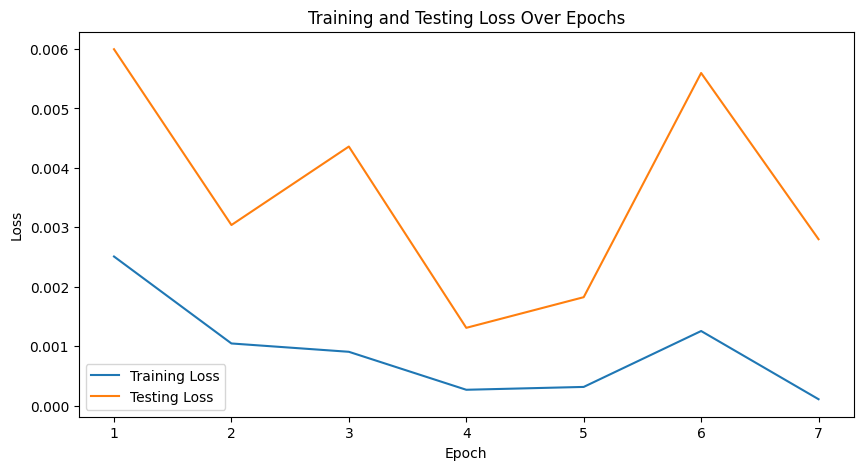

In [19]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), testing_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

The seven epochs used for training was found after experimention, with higher numbers of eopchs generally not resulting in improved detection.

The loss plot shos that the model decreased over the 4 epochs, and then loss beings to increase, perhaps by attempting to overfit to some samples in the training data. With a large number of images for the task, the model learns to general over the large number of samples in fewer epochs than if a smaller dataset was used.

In [20]:
# Model, loss, and optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = ResNetRotationModel(pretrained=True).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

training_losses = []
testing_losses = []

num_epochs = 100
for epoch in range(num_epochs):
  for images, rotation_labels in train_loader:
      images, rotation_labels = images.to(device), rotation_labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, rotation_labels)
      loss.backward()
      optimizer.step()

  # Evaluation
  model.eval()
  test_loss = 0
  with torch.no_grad():
      for test_images, test_rotation_labels in test_loader:
          test_images, test_rotation_labels = test_images.to(device), test_rotation_labels.to(device)
          test_outputs = model(test_images)
          test_loss += criterion(test_outputs, test_rotation_labels).item()

  training_losses.append(loss.item())
  testing_losses.append(test_loss / len(test_loader))
  print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test Loss: {test_loss / len(test_loader)}")

Epoch 1, Loss: 0.003661231603473425, Test Loss: 0.011097573427601702
Epoch 2, Loss: 0.000963584054261446, Test Loss: 0.005304789869114757
Epoch 3, Loss: 0.0009023678721860051, Test Loss: 0.003822904613260771
Epoch 4, Loss: 0.00076997687574476, Test Loss: 0.0038571134685457405
Epoch 5, Loss: 0.00018675398314371705, Test Loss: 0.003120159480969296
Epoch 6, Loss: 0.00043631246080622077, Test Loss: 0.0023919399823965266
Epoch 7, Loss: 0.0001597772934474051, Test Loss: 0.0037272439608747685
Epoch 8, Loss: 0.0006866701296530664, Test Loss: 0.0037226605574168
Epoch 9, Loss: 0.0007112246821634471, Test Loss: 0.0024475113772611605
Epoch 10, Loss: 6.493038381449878e-05, Test Loss: 0.0012190772248730007
Epoch 11, Loss: 0.00017900024249684066, Test Loss: 0.0023940252823873407
Epoch 12, Loss: 4.0062197513179854e-05, Test Loss: 0.0007974964707919132
Epoch 13, Loss: 0.0001111438250518404, Test Loss: 0.0006348553201210702
Epoch 14, Loss: 4.5079170376993716e-05, Test Loss: 0.0007569307614638034
Epoch 1

KeyboardInterrupt: 

The selectino of 100 epochs was to determine through the loss what number of epochs appear to be optima. Training was manually interupted after the loss stagnated and slightly increased for over ten epochs.

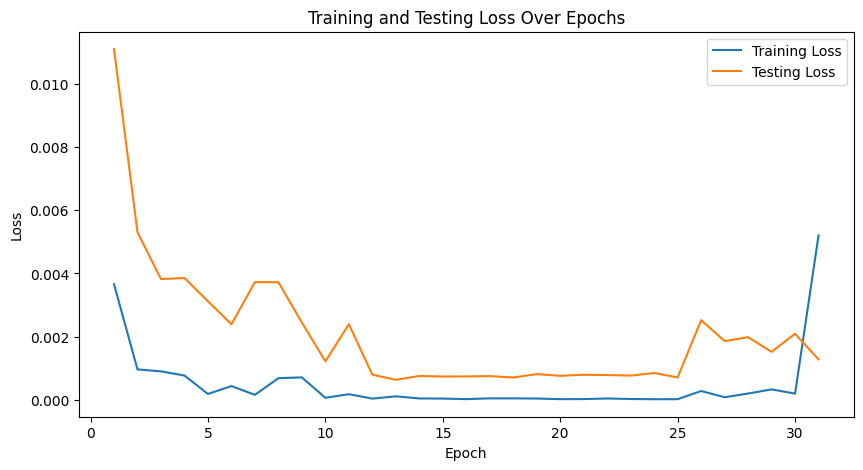

In [27]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, 32), training_losses, label='Training Loss')
plt.plot(range(1, 32), testing_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = ResNetRotationModel(pretrained=True).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

training_losses = []
testing_losses = []

num_epochs = 15
for epoch in range(num_epochs):
  for images, rotation_labels in train_loader:
      images, rotation_labels = images.to(device), rotation_labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, rotation_labels)
      loss.backward()
      optimizer.step()

  # Evaluation
  model.eval()
  test_loss = 0
  with torch.no_grad():
      for test_images, test_rotation_labels in test_loader:
          test_images, test_rotation_labels = test_images.to(device), test_rotation_labels.to(device)
          test_outputs = model(test_images)
          test_loss += criterion(test_outputs, test_rotation_labels).item()

  training_losses.append(loss.item())
  testing_losses.append(test_loss / len(test_loader))
  print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test Loss: {test_loss / len(test_loader)}")

Epoch 1, Loss: 0.006973400712013245, Test Loss: 0.006627678824958229
Epoch 2, Loss: 0.0010638429084792733, Test Loss: 0.003956447409037205
Epoch 3, Loss: 0.0004285168251954019, Test Loss: 0.0030071751056571622
Epoch 4, Loss: 0.0002988426713272929, Test Loss: 0.0027161139567772534
Epoch 5, Loss: 0.00030092004453763366, Test Loss: 0.0020337454901429796
Epoch 6, Loss: 0.018397103995084763, Test Loss: 0.0022527194966050234
Epoch 7, Loss: 8.362682274309918e-05, Test Loss: 0.0007228541152948136
Epoch 8, Loss: 0.0005575873656198382, Test Loss: 0.0022049248670107714
Epoch 9, Loss: 5.4241856560111046e-05, Test Loss: 0.0016297999883958948
Epoch 10, Loss: 3.272327012382448e-05, Test Loss: 0.0015875495287868294
Epoch 11, Loss: 4.011140845250338e-05, Test Loss: 0.0014657654281917429
Epoch 12, Loss: 7.262568396981806e-05, Test Loss: 0.001467494521897433
Epoch 13, Loss: 2.640511593199335e-05, Test Loss: 0.001440813148205745
Epoch 14, Loss: 3.9143596950452775e-05, Test Loss: 0.0014180241205827943
Epoc

### Saving the Model Weights

In [29]:
# Save the trained model's state dictionary
torch.save(model.state_dict(), '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_main_resnet18_15_epochs.pth')

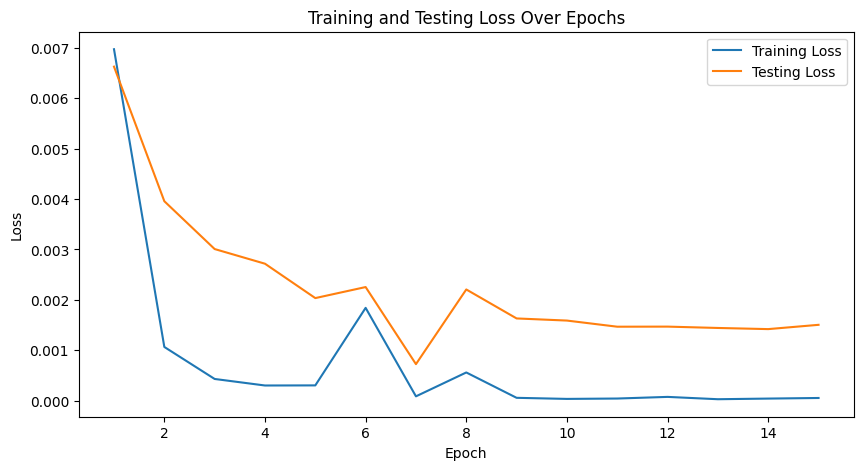

In [39]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), training_losses, label='Training Loss')
plt.plot(range(1, 16), testing_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

In [12]:
# Load saved model weights
model.load_state_dict(torch.load('/content/drive/MyDrive/CV_FinalProj_Data/shuttle_main_resnet18_15_epochs.pth'))

<ipython-input-12-875909d0503f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/CV_FinalProj_Data/shuttle_main_resn

<All keys matched successfully>

## Predictions and Accuracy


In [13]:
predictions = []
model.eval()
with torch.no_grad():
    for test_images, test_rotation_labels in test_loader:
        test_images = test_images.to(device)
        test_outputs = model(test_images)
        predictions.extend(test_outputs.cpu().numpy())

In [15]:
predictions_array = np.array(predictions)
orig = []

for val in test_annotations.iloc[:, 1:4].values:
  orig.append(val)

orig_array = np.array(orig)

predictions_degrees = predictions_array * 180.0
orig_degrees = orig_array * 180.0

differences = orig_degrees - predictions_degrees
differences = np.abs(differences)

differences_df = pd.DataFrame(differences, columns=['x', 'y', 'z'])

x_avg = differences_df['x'].mean()
y_avg = differences_df['y'].mean()
z_avg = differences_df['z'].mean()

print(f"Average difference in x: {x_avg}")
print(f"Average difference in y: {y_avg}")
print(f"Average difference in z: {z_avg}")

differences_df.head(10)

Average difference in x: 1.2951040940692562
Average difference in y: 1.9757596896364253
Average difference in z: 0.5013547669784214


,x,y,z
0,0.030632,2.529656,0.836502
1,2.316715,3.257859,0.186249
2,3.019455,0.957499,0.323578
3,1.731035,2.092355,0.733032
4,0.244990,1.034051,0.489090
5,1.814586,0.020627,0.822937
6,0.429987,1.093342,0.146164
7,0.006338,0.106062,0.528625
8,0.250324,4.471620,0.611694
9,0.370983,0.767749,0.454147


In [19]:
predictions_array = np.array(predictions)
orig = []

for val in test_annotations.iloc[:, 1:4].values:
  orig.append(val)

orig_array = np.array(orig)

predictions_degrees = predictions_array * 180.0
orig_degrees = orig_array * 180.0

differences = orig_degrees - predictions_degrees
differences = np.abs(differences)

differences_df = pd.DataFrame(differences, columns=['x', 'y', 'z'])

x_avg = differences_df['x'].mean()
y_avg = differences_df['y'].mean()
z_avg = differences_df['z'].mean()

print(f"Average difference in x: {x_avg}")
print(f"Average difference in y: {y_avg}")
print(f"Average difference in z: {z_avg}")

differences_df.head(10)




Average difference in x: 2.760794118410705
Average difference in y: 5.993273260956971
Average difference in z: 1.7534514445668368


,x,y,z
0,1.865738,6.730798,4.652481
1,2.446438,7.724503,2.065948
2,3.196534,0.548869,2.474045
3,1.555662,1.826883,0.031326
4,1.009450,7.484437,2.844788
5,0.899486,1.838891,4.359573
6,0.293295,4.814823,1.943695
7,6.109125,2.295962,4.314133
8,4.980198,17.045195,5.376373
9,5.456059,17.745663,3.732147


# test the resnet 18 on closer images on real world data

In [20]:
import zipfile
import os

from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_rw_45degs.zip'
extract_dir = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs'

# Create the extract directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


experiment****************************************************************

In [19]:
real_rots = pd.read_csv('/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs/shuttle_rw_45degs/angles.csv', sep=",")

real_rots['X'] = (real_rots['X'] - 180.0) / 180.0
real_rots['Y'] = (real_rots['Y'] - 180.0)/ 180.0
real_rots['Z'] = (real_rots['Z'] - 180.0)/ 180.0

real_rots.tail(5)

# Path to the new test images and their labels
new_test_images = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs/shuttle_rw_45degs/images/'
new_test_annotations_file = real_rots  # DataFrame containing labels for the new test images

# Reuse the same transform pipeline
new_transform = transform  # Already defined

# Create a new dataset and dataloader for the new test images
new_test_dataset = RotationDataset(image_dir=new_test_images, annotations=new_test_annotations_file, transform=new_transform)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False, num_workers=4)

predictions = []
model.eval()
with torch.no_grad():
    for test_images, test_rotation_labels in new_test_loader:
        test_images = test_images.to(device)
        test_outputs = model(test_images)
        predictions.extend(test_outputs.cpu().numpy())


predictions_array = np.array(predictions)
orig = []

for val in new_test_annotations_file.iloc[:, 1:4].values:
  orig.append(val)

orig_array = np.array(orig)

predictions_degrees = predictions_array * 180.0
orig_degrees = orig_array * 180.0

differences = []

def Get_Difference(a, b):
  differences = []
  for i in range (0, len(a)):
    diff_a = 180
    if (a[i] < 0) and (b[i] > 0):
      diff_a = abs((a[i] + 180) - (b[i]+180))
    elif (a[i] > 0 and b[i] < 0):
      diff_a = abs((a[i] - 180) - (b[i] - 180))
    diff_b = abs(a[i] - b[i])
    differences.append(min(diff_a, diff_b))
  return differences


x_diff = Get_Difference(orig_array[:, 0]*180, predictions_array[:,0]*180)
y_diff = Get_Difference(orig_array[:, 1]*180, predictions_array[:,1]*180)
z_diff = Get_Difference(orig_array[:, 2]*180, predictions_array[:,2]*180)

differences = np.array([x_diff, y_diff, z_diff])
differences = differences.T


differences_df = pd.DataFrame(differences, columns=['X', 'Y', 'Z'])

x_avg = np.mean(x_diff)
y_avg = np.mean(y_diff)
z_avg = np.mean(z_diff)


print(f"Average difference in x: {x_avg}")
print(f"Average difference in y: {y_avg}")
print(f"Average difference in z: {z_avg}")

x_mean = np.median(x_diff)
y_mean = np.median(y_diff)
z_mean = np.median(z_diff)

print(f"Median difference in x: {x_mean}")
print(f"Median difference in y: {y_mean}")
print(f"Median difference in z: {z_mean}")

differences_df.head(10)


Average difference in x: 9.59817626412991
Average difference in y: 17.243003705631843
Average difference in z: 1.924340037118017
Median difference in x: 8.545345306396484
Median difference in y: 6.701416015625
Median difference in z: 1.1743850708007812


,X,Y,Z
0,0.328568,0.648335,0.514145
1,6.304512,2.182577,1.111343
2,1.605530,5.214989,1.320312
3,9.764786,6.367701,1.642029
4,1.779404,2.172717,2.904358
5,21.739616,6.057485,0.958176
6,3.387909,8.928099,0.537491
7,7.841515,1.698601,0.380569
8,12.298187,5.078304,2.359650
9,2.753616,1.758762,1.092026


experiment********************************************************************

### Usage on single image

In [31]:
model.eval()

def ReturnResultOnSingleImage(image_path):
  img = Image.open(image_path).convert("RGB")


  # Define the transformation pipeline
  transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize to match model input
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
  ])

  # Apply transformations
  img = transform(img)  # This will handle both resizing and normalization

  # Add batch dimension
  img = img.unsqueeze(0)

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  with torch.no_grad():
    test_images = img.to(device)
    test_outputs = model(test_images)
    prediction = test_outputs.cpu().numpy()

  return prediction * 180


In [33]:
new_test_annotations_file.head(5)

pred_rot = ReturnResultOnSingleImage('/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs/shuttle_rw_45degs/images/IMG_4222.png')
print(pred_rot)
print(new_test_annotations_file.iloc[0]['X']*180, new_test_annotations_file.iloc[0]['Y']*180, new_test_annotations_file.iloc[0]['Z']*180)

[[ -90.32676      0.6448798 -180.51277  ]]
-90.0 0.0 -180.0


end usage on single image

In [28]:
real_rots = pd.read_csv('/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs/shuttle_rw_45degs/angles.csv', sep=",")

real_rots['X'] = (real_rots['X'] - 180.0) / 180.0
real_rots['Y'] = (real_rots['Y'] - 180.0)/ 180.0
real_rots['Z'] = (real_rots['Z'] - 180.0)/ 180.0

real_rots.tail(5)

# Path to the new test images and their labels
new_test_images = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs/shuttle_rw_45degs/images/'
new_test_annotations_file = real_rots  # DataFrame containing labels for the new test images

# Reuse the same transform pipeline
new_transform = transform  # Already defined

# Create a new dataset and dataloader for the new test images
new_test_dataset = RotationDataset(image_dir=new_test_images, annotations=new_test_annotations_file, transform=new_transform)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False, num_workers=4)

predictions = []
model.eval()
with torch.no_grad():
    for test_images, test_rotation_labels in new_test_loader:
        test_images = test_images.to(device)
        test_outputs = model(test_images)
        predictions.extend(test_outputs.cpu().numpy())

,Image File,X,Y,Z
221,IMG_4662.png,-0.75,0.5,-1.0
222,IMG_4670.png,-0.75,0.5,-1.0
223,IMG_4677.png,-0.75,0.5,-1.0
224,IMG_4685.png,-0.75,0.5,-1.0
225,IMG_4693.png,-0.75,0.5,-1.0


In [29]:
# Path to the new test images and their labels
new_test_images = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs/shuttle_rw_45degs/images/'
new_test_annotations_file = real_rots  # DataFrame containing labels for the new test images

# Reuse the same transform pipeline
new_transform = transform  # Already defined

# Create a new dataset and dataloader for the new test images
new_test_dataset = RotationDataset(image_dir=new_test_images, annotations=new_test_annotations_file, transform=new_transform)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False, num_workers=4)

predictions = []
model.eval()
with torch.no_grad():
    for test_images, test_rotation_labels in new_test_loader:
        test_images = test_images.to(device)
        test_outputs = model(test_images)
        predictions.extend(test_outputs.cpu().numpy())


In [ ]:
live_test_img/folder = 'path goes here'


In [53]:
predictions_array = np.array(predictions)
orig = []

for val in new_test_annotations_file.iloc[:, 1:4].values:
  orig.append(val)

orig_array = np.array(orig)

predictions_degrees = predictions_array * 180.0
orig_degrees = orig_array * 180.0

differences = []

def Get_Difference(a, b):
  differences = []
  for i in range (0, len(a)):
    diff_a = 180
    if (a[i] < 0) and (b[i] > 0):
      diff_a = abs((a[i] + 180) - (b[i]+180))
    elif (a[i] > 0 and b[i] < 0):
      diff_a = abs((a[i] - 180) - (b[i] - 180))
    diff_b = abs(a[i] - b[i])
    differences.append(min(diff_a, diff_b))
  return differences


x_diff = Get_Difference(orig_array[:, 0]*180, predictions_array[:,0]*180)
y_diff = Get_Difference(orig_array[:, 1]*180, predictions_array[:,1]*180)
z_diff = Get_Difference(orig_array[:, 2]*180, predictions_array[:,2]*180)

differences = np.array([x_diff, y_diff, z_diff])
differences = differences.T


differences_df = pd.DataFrame(differences, columns=['X', 'Y', 'Z'])

x_avg = np.mean(x_diff)
y_avg = np.mean(y_diff)
z_avg = np.mean(z_diff)


print(f"Average difference in x: {x_avg}")
print(f"Average difference in y: {y_avg}")
print(f"Average difference in z: {z_avg}")

x_mean = np.median(x_diff)
y_mean = np.median(y_diff)
z_mean = np.median(z_diff)

print(f"Mean difference in x: {x_mean}")
print(f"Mean difference in y: {y_mean}")
print(f"Mean difference in z: {z_mean}")

differences_df.head(10)
print(x_diff)

Average difference in x: 12.054029954218231
Average difference in y: 32.23366303280392
Average difference in z: 3.3058475730693444
Mean difference in x: 11.380596160888672
Mean difference in y: 11.200945854187012
Mean difference in z: 2.58428955078125
[7.365303039550781, 0.179107666015625, 15.182411193847656, 21.783355712890625, 23.695266723632812, 13.366218566894531, 0.7610321044921875, 6.128662109375, 8.597007751464844, 0.5527191162109375, 16.570709228515625, 12.380928039550781, 9.837882995605469, 15.051437377929688, 16.917808532714844, 3.62530517578125, 12.000480651855469, 1.1167831420898438, 5.218345642089844, 14.082870483398438, 2.1899261474609375, 9.640640258789062, 18.081443786621094, 5.113868713378906, 7.3324432373046875, 14.203147888183594, 11.799713134765625, 14.022193908691406, 6.596466064453125, 3.2951889038085938, 10.252037048339844, 20.61310577392578, 6.878120422363281, 10.820274353027344, 11.011421203613281, 5.709617614746094, 4.037193298339844, 3.3646926879882812, 0.013

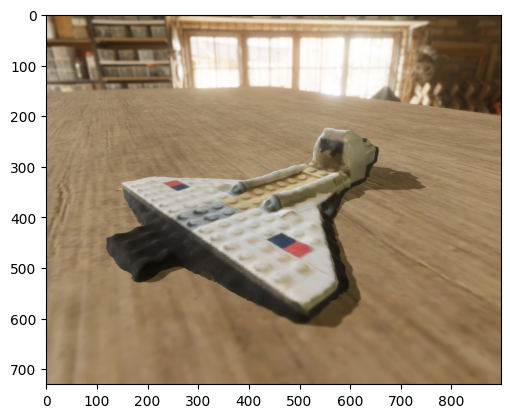

In [ ]:
# display image at sequence.0/step0.camera.png
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

shuttle_images_dir = '/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/solo/'
img = Image.open(os.path.join(shuttle_images_dir, "sequence.11/step0.camera.png"))
plt.imshow(img)

# Cropped Edition



In [ ]:
import os
import math

In [ ]:
images_dir = '/content/drive/MyDrive/CV_FinalProj_Data/Shuttle_main_cropped/images'
labels_dir = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_main/shuttle_main_rotations.txt'

In [ ]:
labels_df = pd.read_csv(labels_dir, header=None)
labels_df['image name'] = ""
for idx, fow in enumerate(os.listdir(images_dir)):
  labels_df.loc[idx, 'image name'] = 'sequence.' + str(idx) + '.png'
# rename the first 3 columns to x,y, and z
labels_df = labels_df.rename(columns={0: 'x'})
labels_df = labels_df.rename(columns={1: 'y'})
labels_df = labels_df.rename(columns={2: 'z'})
labels_df = labels_df.reindex(columns=['image name', 'x', 'y', 'z'])
# normalize the x and y columns by subtracting 180 and then dividing by 180


In [ ]:
labels_df[['x', 'y', 'z']] = (labels_df[['x', 'y', 'z']] - 180.0) / 180.0

In [ ]:
labels_df.head(5)

,image name,x,y,z
0,sequence.0.png,-0.717339,-0.115415,-1.0
1,sequence.1.png,-0.938051,-0.552221,-1.0
2,sequence.2.png,-0.695901,-0.770674,-1.0
3,sequence.3.png,-0.751306,-0.265214,-1.0
4,sequence.4.png,-0.723213,-0.170456,-1.0


In [ ]:
# multiply by 180 and add 180
labels_df_old = labels_df.copy()
labels_df_old[['x', 'y', 'z']] = labels_df[['x', 'y', 'z']] * 180.0 + 180.0
labels_df_old.head(5)

,image name,x,y,z
0,sequence.0.png,50.8789,159.2253,0.0
1,sequence.1.png,11.1509,80.6002,0.0
2,sequence.2.png,54.7378,41.2786,0.0
3,sequence.3.png,44.7649,132.2614,0.0
4,sequence.4.png,49.8217,149.3180,0.0


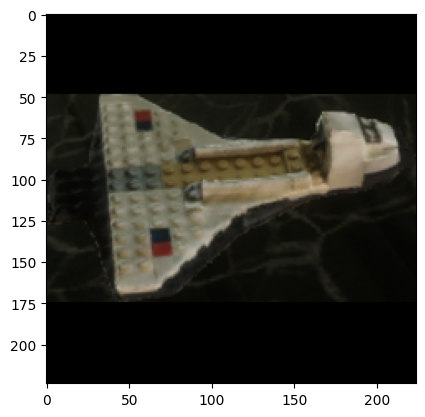

In [ ]:
from torchvision import transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
image_path = "/content/drive/MyDrive/CV_FinalProj_Data/Shuttle_main_cropped/images/sequence.6.png"

# resize to transforms.Resize((224, 224)),
img = Image.open(image_path).convert("RGB")
img = resize_with_padding(img, target_size=(224, 224), fill=(0, 0, 0))
plt.imshow(img)

In [ ]:
print(images_dir)

/content/drive/MyDrive/CV_FinalProj_Data/Shuttle_main_cropped/images


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F



# Define the custom model
class ResNetRotationModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetRotationModel, self).__init__()
        # Load a pre-trained ResNet model
        self.backbone = models.resnet50(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        # Replace the fully connected layer with a custom head for regression
        self.backbone.fc = nn.Linear(num_features, 3)  # Output x, y, z rotations

    def forward(self, x):
        return self.backbone(x)

# Define a custom dataset
class RotationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        # Load image
        img_name = os.path.join(self.image_dir, str(self.annotations.iloc[idx, 0]))
        image = Image.open(img_name).convert("RGB")

        # Load rotation labels (x, y, z)
        rotation_labels = self.annotations.iloc[idx, 1:4].values.astype('float')
        rotation_labels = torch.tensor(rotation_labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, rotation_labels

# Paths
images = images_dir
annotations_file = labels_df

def resize_with_padding(img, target_size=(224, 224), fill=(0, 0, 0)):
    original_width, original_height = img.size
    target_width, target_height = target_size
    aspect_ratio = original_width / original_height

    # Calculate new dimensions
    if aspect_ratio > 1:  # Wider than tall
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:  # Taller than wide
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Resize the image
    resized_img = img.resize((new_width, new_height))

    # Add padding to center the image
    padded_img = ImageOps.expand(
        resized_img,
        border=(
            (target_width - new_width) // 2,
            (target_height - new_height) // 2,
            (target_width - new_width + 1) // 2,
            (target_height - new_height + 1) // 2,
        ),
        fill=fill,
    )
    return padded_img

# Define the transforms.Compose pipeline
transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_with_padding(img, target_size=(224, 224), fill=(0, 0, 0))),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ResNet
])



# Split data
train_annotations, test_annotations = train_test_split(annotations_file, test_size=0.2, random_state=42)


train_dataset = RotationDataset(image_dir=images, annotations=train_annotations, transform=transform)
test_dataset = RotationDataset(image_dir=images, annotations=test_annotations, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Model, loss, and optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = ResNetRotationModel(pretrained=True).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, rotation_labels in train_loader:
        images, rotation_labels = images.to(device), rotation_labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, rotation_labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for test_images, test_rotation_labels in test_loader:
            test_images, test_rotation_labels = test_images.to(device), test_rotation_labels.to(device)
            test_outputs = model(test_images)
            test_loss += criterion(test_outputs, test_rotation_labels).item()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test Loss: {test_loss / len(test_loader)}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.08749908208847046, Test Loss: 0.12246440824062105
Epoch 2, Loss: 0.1432625651359558, Test Loss: 0.12034300708818058
Epoch 3, Loss: 0.11856242269277573, Test Loss: 0.12050046416975203
Epoch 4, Loss: 0.11369520425796509, Test Loss: 0.12507592194846698
Epoch 5, Loss: 0.11713434755802155, Test Loss: 0.1379903027462581
Epoch 6, Loss: 0.09095199406147003, Test Loss: 0.1512274785292527
Epoch 7, Loss: 0.051060765981674194, Test Loss: 0.16124791515961526
Epoch 8, Loss: 0.0254680123180151, Test Loss: 0.15302635534178644
Epoch 9, Loss: 0.017315536737442017, Test Loss: 0.1515230436528486
Epoch 10, Loss: 0.031265828758478165, Test Loss: 0.14800380619745407


In [ ]:
# prompt: # get predictions and compare to original, then multiply both by 180 and get average difference

predictions = []
model.eval()
with torch.no_grad():
    for test_images, test_rotation_labels in test_loader:
        test_images = test_images.to(device)
        test_outputs = model(test_images)
        predictions.extend(test_outputs.cpu().numpy())
predictions_array = np.array(predictions)
orig = []

for val in test_annotations.iloc[:, 1:4].values:
  orig.append(val)

orig_array = np.array(orig)

predictions_degrees = predictions_array * 180.0
orig_degrees = orig_array * 180.0

differences = orig_degrees - predictions_degrees
differences = np.abs(differences)

differences_df = pd.DataFrame(differences, columns=['x', 'y', 'z'])

x_avg = differences_df['x'].mean()
y_avg = differences_df['y'].mean()
z_avg = differences_df['z'].mean()

print(f"Average difference in x: {x_avg}")
print(f"Average difference in y: {y_avg}")
print(f"Average difference in z: {z_avg}")

differences_df.head(10)

Average difference in x: 25.638549886737913
Average difference in y: 96.96026098789615
Average difference in z: 1.3987358992344199


,x,y,z
0,20.547286,120.010142,4.417999
1,10.865977,4.980507,2.590668
2,3.833603,155.534386,1.545380
3,29.075725,36.584063,1.103897
4,27.883676,11.522525,2.342133
5,29.956245,148.099441,0.033920
6,4.944537,117.893517,1.109634
7,14.045554,156.824156,0.650192
8,47.167326,182.751873,2.366913
9,39.780833,143.265802,0.956284


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/USD/rotation_resnet_model.pth')

In [ ]:
import zipfile
import os

from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_data.zip'
extract_dir = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_data'

# Create the extract directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
real_rots = []

for idx in range(0,298):
  rot_file = os.path.join(extract_dir,'shuttle_realworld_data','rot_' + str(idx) + '.txt')
  with open(rot_file, 'r') as f:
    rot_text = f.read()
    rot_vals = rot_text.split('\n')[0]
    rot_vals = rot_vals.split(',')
    rot_vals = [float(val) for val in rot_vals]
    real_rots.append(rot_vals)


In [ ]:
real_data = pd.DataFrame(real_rots, columns=['x', 'y', 'z'])
real_data.head(5)

,x,y,z
0,289.7448,359.6056,187.5341
1,289.7448,359.6056,187.5341
2,291.5407,183.4960,1.3609
3,291.5407,183.4960,1.3609
4,291.5407,183.4960,1.3609


In [ ]:
real_data['image name'] = ""
for idx in range(0,298):
  real_data.loc[idx, 'image name'] = 'SavedTexture' + str(idx) + '.png'

In [ ]:
real_data = real_data.reindex(columns=['image name', 'x', 'y', 'z'])
real_data.head(5)

normalized_real_data = real_data.copy()
normalized_real_data[['x', 'y', 'z']] = (normalized_real_data[['x', 'y', 'z']] - 180.0) / 180.0
normalized_real_data.head(5)

,image name,x,y,z
0,SavedTexture0.png,0.609693,0.997809,0.041856
1,SavedTexture1.png,0.609693,0.997809,0.041856
2,SavedTexture2.png,0.619671,0.019422,-0.992439
3,SavedTexture3.png,0.619671,0.019422,-0.992439
4,SavedTexture4.png,0.619671,0.019422,-0.992439


In [ ]:
normalized_real_data.head()

,image name,x,y,z
0,SavedTexture0.png,0.609693,0.997809,0.041856
1,SavedTexture1.png,0.609693,0.997809,0.041856
2,SavedTexture2.png,0.619671,0.019422,-0.992439
3,SavedTexture3.png,0.619671,0.019422,-0.992439
4,SavedTexture4.png,0.619671,0.019422,-0.992439


In [ ]:
def predict_rotation(image_path, model):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    euler_angles = output.squeeze().cpu().numpy()
    euler_angles_degrees = tuple(euler_angles)  * 180.0

    return euler_angles_degrees
